In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp
import rubin_sim.maf as maf
import rubin_scheduler.utils as rsUtils
import rubin_sim.data as data

# Set RUBIN_SIM_DATA_DIR environment variable
os.environ['RUBIN_SIM_DATA_DIR'] = '/data/a.saricaoglu/repo/RubinsForge/rubin_sim_data'

print(f"Current working directory: {os.getcwd()}")
print(f"RUBIN_SIM_DATA_DIR set to: {os.environ.get('RUBIN_SIM_DATA_DIR')}")
print(f'version of rubin_sim: {data.data_dict()}')

Current working directory: /data/a.saricaoglu/repo/RubinsForge/OpSim/scripts
RUBIN_SIM_DATA_DIR set to: /data/a.saricaoglu/repo/RubinsForge/rubin_sim_data
version of rubin_sim: {'maf': 'maf_2024_06_13.tgz', 'maps': 'maps_2022_2_28.tgz', 'movingObjects': 'movingObjects_oct_2021.tgz', 'orbits': 'orbits_2022_3_1.tgz', 'orbits_precompute': 'orbits_precompute_2023_05_23.tgz', 'sim_baseline': 'sim_baseline_2025_03_03.tgz', 'skybrightness': 'skybrightness_2023_09_11.tgz', 'throughputs': 'throughputs_2023_09_22.tgz', 'tests': 'tests_2024_04_23.tgz'}


In [5]:
import os
import rubin_sim.maf as maf

# Method 1: Direct path to a specific database file
baseline_file = '/data/a.saricaoglu/repo/RubinsForge/rubin_sim_data/sim_baseline/your_actual_database.db'

# Method 2: Find the first available .db file
data_dir = '/data/a.saricaoglu/repo/RubinsForge/rubin_sim_data/sim_baseline'
db_files = [f for f in os.listdir(data_dir) if f.endswith('.db') and f != 'baseline.db']

if db_files:
    baseline_file = os.path.join(data_dir, db_files[0])
    print(f"Using database: {baseline_file}")
else:
    print("No database files found!")
    baseline_file = None

if baseline_file and os.path.exists(baseline_file):
    name = os.path.basename(baseline_file).replace('.db','')
    out_dir = 'temp'
    results_db = maf.db.ResultsDb(out_dir=out_dir)
    print(f"Successfully using baseline database: {baseline_file}")
else:
    print(f"Database file not found: {baseline_file}")

Using database: /data/a.saricaoglu/repo/RubinsForge/rubin_sim_data/sim_baseline/baseline_v4.3.1_10yrs.db
Successfully using baseline database: /data/a.saricaoglu/repo/RubinsForge/rubin_sim_data/sim_baseline/baseline_v4.3.1_10yrs.db


In [6]:
baseline_file = '/data/a.saricaoglu/repo/RubinsForge/rubin_sim_data/sim_baseline/baseline_v4.0_10yrs.db'
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)
print(f"Using baseline database: {baseline_file}")
print(results_db)

Using baseline database: /data/a.saricaoglu/repo/RubinsForge/rubin_sim_data/sim_baseline/baseline_v4.0_10yrs.db


WE need to get coordinates for desired targets from the csv file. (Will be removed and put in utils script later on)

In [24]:
import astropy.units as u
from astropy.coordinates import SkyCoord

# Read the CSV file and examine its structure
df = pd.read_csv('/data/a.saricaoglu/repo/RubinsForge/LenSim/output.csv')

print("CSV file structure:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nData types:")
print(df.dtypes)

# Create targets dictionary with all requested fields
targets = {}

for index, row in df.iterrows():
    # Create SkyCoord object for each target
    coord = SkyCoord(ra=row['ra'] * u.degree, dec=row['dec'] * u.degree, frame='icrs')
    
    # Create target ID (you can modify this naming scheme)
    target_id = f"target_{index:04d}"
    
    # Build the target dictionary with all requested fields
    targets[target_id] = {
        'ra': row['ra'],  # degrees
        'dec': row['dec'],  # degrees
        'coord': coord,  # SkyCoord object for convenience
        
        # Initialize other fields - update these based on your CSV columns
        'name': row.get('name',None),  # Use CSV value if exists, else default name
        'flag': row.get('flag', None),
        'n_img': row.get('n_img', None),  # Use CSV value if exists, else None
        'image_conf': row.get('image_conf', None),
        'lens_type': row.get('lens_type', None),
        'source_type': row.get('source_type', None),
        'mag': row.get('mag', None),
        'Dmag': row.get('Dmag', None), 
        'value': row.get('value', None),
        'dvalue_min': row.get('dvalue_min', None),
        'dvalue_max': row.get('dvalue_max', None),
        
    }

print(f"\nCreated targets dictionary with {len(targets)} targets")
print(f"Target IDs: {list(targets.keys())[:5]}...")  # Show first 5 IDs
print(f'Number of candidates: {len([t for t in targets.values() if t["flag"]=="CANDIDATE"])}')
print(f'Number of confirmed: {len([t for t in targets.values() if t["flag"]=="CONFIRMED"])}')
# Show structure of first target
first_target_id = list(targets.keys())[0]
print(f"\nStructure of {first_target_id}:")
for key, value in targets[first_target_id].items():
    if key != 'coord':  # Skip coord object for cleaner display
        print(f"  {key}: {value}")

# Also create a SkyCoord array for convenience (as in original code)
coordinates = SkyCoord([targets[tid]['coord'] for tid in targets.keys()])

CSV file structure:
Shape: (17842, 13)
Columns: ['ra', 'dec', 'name', 'alt_name', 'flag', 'score', 'image_sep', 'info', 'n_img', 'image_conf', 'lens_type', 'source_type', 'contaminant_type']

First few rows:
          ra      dec            name  \
0  149.84070  2.11067  J095921+020638   
1  149.85618  2.11212  J095925+020643   
2  149.87958  2.04139  J095931+020229   
3  149.89480  2.10936  J095934+020633   
4  149.99875  2.06333  J095959+020347   

                                            alt_name       flag  score  \
0  095921+020638, J095921+020638, J09h59m21.768s ...  CONFIRMED    NaN   
1                                                NaN  CANDIDATE    2.0   
2                                                NaN  CANDIDATE    2.0   
3                                                NaN  CANDIDATE    2.0   
4                                                NaN  CANDIDATE    2.0   

   image_sep info  n_img image_conf   lens_type           source_type  \
0       1.38  NaN    NaN   

In [8]:
# Now, we filter the lenses that are observable from Rubin at a given time

import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline
from rubin_scheduler.utils import ra_dec2_hpid, hpid2_ra_dec
from rubin_scheduler.scheduler.utils import CurrentAreaMap, SkyAreaGeneratorGalplane, SkyAreaGenerator

# How to set RUBIN_SIM_DATA_DIR

# Method 1: Set it temporarily in the notebook (for this session only)
import os

# Check if it's already set
if not os.environ.get('RUBIN_SIM_DATA_DIR'):
    # Set it to the common location - adjust path as needed
    rubin_data_path = '/data/a.saricaoglu/repo/RubinsForge/rubin_sim_data'
    
    # Check if the directory exists
    if os.path.exists(rubin_data_path):
        os.environ['RUBIN_SIM_DATA_DIR'] = rubin_data_path
        print(f"✅ Set RUBIN_SIM_DATA_DIR to: {rubin_data_path}")

else:
    print(f"✅ RUBIN_SIM_DATA_DIR already set to: {os.environ['RUBIN_SIM_DATA_DIR']}")

# Verify it's set correctly
final_dir = os.environ.get('RUBIN_SIM_DATA_DIR')
if final_dir and os.path.exists(final_dir):
    print(f"\n✅ Successfully configured: {final_dir}")
 

✅ RUBIN_SIM_DATA_DIR already set to: /data/a.saricaoglu/repo/RubinsForge/rubin_sim_data

✅ Successfully configured: /data/a.saricaoglu/repo/RubinsForge/rubin_sim_data


In [25]:
from rubin_scheduler.scheduler.utils import EuclidOverlapFootprint
nside = 64
fpg = EuclidOverlapFootprint(nside=nside)
maps_arr, labels = fpg.return_maps()
# Now, check how many targets are inside the footprint
# targets_in_footprint = []
# Create targets dictionary with all requested fields
targets_in_footprint = {}

for index, row in df.iterrows():
    # Create SkyCoord object for each target
    coord = SkyCoord(ra=row['ra'] * u.degree, dec=row['dec'] * u.degree, frame='icrs')
    hpid = ra_dec2_hpid(nside, row['ra'], row['dec'])
    healpixval = 0
    for filtername in 'ugrizy':
        healpixval += maps_arr[filtername][hpid]
    if healpixval > 0:
        # targets_in_footprint.append(coord)
        
        # Create target ID (you can modify this naming scheme)
        target_id = f"target_{index:04d}"
        
        # Build the target dictionary with all requested fields
        targets_in_footprint[target_id] = {
            'ra': row['ra'],  # degrees
            'dec': row['dec'],  # degrees
            'coord': coord,  # SkyCoord object for convenience
            
            # Initialize other fields - update these based on your CSV columns
            'name': row.get('name',None),  # Use CSV value if exists, else default name
            'flag': row.get('flag', None),
            'n_img': row.get('n_img', None),  # Use CSV value if exists, else None
            'image_conf': row.get('image_conf', None),
            'lens_type': row.get('lens_type', None),
            'source_type': row.get('source_type', None),
            'mag': row.get('mag', None),
            'Dmag': row.get('Dmag', None), 
            'value': row.get('value', None),
            'dvalue_min': row.get('dvalue_min', None),
            'dvalue_max': row.get('dvalue_max', None),
            
        }

print(f"\nCreated targets dictionary with {len(targets_in_footprint)} targets")
print(f"Target IDs: {list(targets_in_footprint.keys())[:5]}...")  # Show first 5 IDs
print(f'Number of candidates: {len([t for t in targets_in_footprint.values() if t["flag"]=="CANDIDATE"])}')
print(f'Number of confirmed: {len([t for t in targets_in_footprint.values() if t["flag"]=="CONFIRMED"])}')
# Show structure of first target
first_target_id = list(targets_in_footprint.keys())[0]
print(f"\nStructure of {first_target_id}:")
for key, value in targets_in_footprint[first_target_id].items():
    if key != 'coord':  # Skip coord object for cleaner display
        print(f"  {key}: {value}")

# Also create a SkyCoord array for convenience (as in original code)
coordinates = SkyCoord([targets_in_footprint[tid]['coord'] for tid in targets_in_footprint.keys()])
names = [targets_in_footprint[tid]['name'] for tid in targets_in_footprint.keys()]


Created targets dictionary with 13746 targets
Target IDs: ['target_0000', 'target_0001', 'target_0002', 'target_0003', 'target_0004']...
Number of candidates: 13156
Number of confirmed: 590

Structure of target_0000:
  ra: 149.8407
  dec: 2.11067
  name: J095921+020638
  flag: CONFIRMED
  n_img: nan
  image_conf: []
  lens_type: ['GALAXY']
  source_type: ['GALAXY', 'QUASAR']
  mag: None
  Dmag: None
  value: None
  dvalue_min: None
  dvalue_max: None


In [26]:
from rubin_scheduler.scheduler.utils import EuclidOverlapFootprint
nside = 64
fpg = EuclidOverlapFootprint(nside=nside)
maps_arr, labels = fpg.return_maps()

EuLd_pix = np.where((labels == 'lowdust') | (labels == "euclid_overlap"))[0]
coordinates_in_EuLd = []
ids = []
euld_names = []
euld_flags = []
for target in targets_in_footprint.keys():
    coord = targets_in_footprint[target]['coord']
    hpid = ra_dec2_hpid(nside, coord.ra.degree, coord.dec.degree)
    healpixval = 0
    for filtername in 'ugrizy':
        healpixval += maps_arr[filtername][hpid]
    if (healpixval > 0) & (hpid in EuLd_pix):
        ids.append(target)
        coordinates_in_EuLd.append(coord)
        euld_names.append(targets_in_footprint[target]['name'])
        euld_flags.append(targets_in_footprint[target]['flag'])
coordinates_in_EuLd = SkyCoord(coordinates_in_EuLd)
# print(f"Number of total lenses: {len(coordinates)}")
print(f'Number of candidates: {len([t for t in euld_flags if t=="CANDIDATE"])}')
print(f'Number of confirmed: {len([t for t in euld_flags if t=="CONFIRMED"])}')
print(f"Number of lenses in Euclid/Lowdust region: {len(coordinates_in_EuLd)}")
print(f"Number of lenses in footprint {len(coordinates)}")
print(ids)
print(len(euld_names), len(names))


Number of candidates: 12498
Number of confirmed: 527
Number of lenses in Euclid/Lowdust region: 13025
Number of lenses in footprint 13746
['target_0000', 'target_0001', 'target_0002', 'target_0003', 'target_0004', 'target_0005', 'target_0007', 'target_0008', 'target_0010', 'target_0011', 'target_0012', 'target_0013', 'target_0014', 'target_0017', 'target_0018', 'target_0019', 'target_0021', 'target_0022', 'target_0023', 'target_0024', 'target_0026', 'target_0027', 'target_0028', 'target_0029', 'target_0030', 'target_0031', 'target_0032', 'target_0033', 'target_0034', 'target_0035', 'target_0036', 'target_0037', 'target_0038', 'target_0039', 'target_0041', 'target_0042', 'target_0044', 'target_0045', 'target_0047', 'target_0048', 'target_0049', 'target_0050', 'target_0051', 'target_0052', 'target_0053', 'target_0055', 'target_0056', 'target_0057', 'target_0059', 'target_0060', 'target_0061', 'target_0062', 'target_0063', 'target_0064', 'target_0065', 'target_0066', 'target_0067', 'targe

In [22]:
# Save target positions to a file for later use
import astropy.io.fits as fits
from astropy.table import Table
import os
repo_path = os.path.join(os.getcwd(), '../..')
fits_filename = os.path.join(repo_path, 'in_LSST_footprint_coordinates.fits')

# Simple ASCII-only cleaning function
def simple_ascii_clean(text):
    """Keep only ASCII characters"""
    if text is None:
        return 'None'
    return ''.join(char for char in str(text) if ord(char) < 128)

# Clean the names
clean_names = [simple_ascii_clean(name) for name in names]
clean_euld_names = [simple_ascii_clean(name) for name in euld_names]

hdu = fits.PrimaryHDU()
hdul = fits.HDUList([hdu])
hdul.writeto(fits_filename, overwrite=True)
hdu = fits.open(fits_filename, mode='update')
coordinates_in_footprint = coordinates

table1 = fits.BinTableHDU(Table(data=[list(targets_in_footprint.keys()), clean_names, coordinates_in_footprint.ra.degree, coordinates_in_footprint.dec.degree], names=['Target_no', 'SLEDName', 'RA', 'DEC'], units=['', '', 'deg', 'deg']))
table2 = fits.BinTableHDU(Table(data=[ids, clean_euld_names, coordinates_in_EuLd.ra.degree, coordinates_in_EuLd.dec.degree], names=['Target_no', 'SLEDName', 'RA', 'DEC'], units=['', '', 'deg', 'deg']))
table1.header['EXTNAME'] = 'In_LSST_Footprint'
table2.header['EXTNAME'] = 'In_Euclid_Lowdust_Region'
table1.header['NOBJ'] = len(coordinates_in_footprint)
table2.header['NOBJ'] = len(coordinates_in_EuLd)
table1.header['COMMENT'] = "Lenses inside LSST footprint in any band"
table2.header['COMMENT'] = "Lenses inside Euclid overlap and lowdust region"

hdu.append(table1)
hdu.append(table2)
hdu.flush()

In [10]:
#  #Convert RA/Dec coordinates to Alt-Az for a specific location and time
# from astropy.time import Time
# from astropy.coordinates import EarthLocation, AltAz
# import datetime

# # Set up observer location (Rubin Observatory)
# rubin_location = EarthLocation.of_site('Rubin Observatory')
# print(f"Rubin Observatory location: {rubin_location}")

# # Set observation time (current time as example)
# obs_time = Time(datetime.datetime(2025, 8,26,23,0,0))
# print(f"Observation time: {obs_time}")

# # Create AltAz frame for the specific location and time
# altaz_frame = AltAz(obstime=obs_time, location=rubin_location)

# # Transform our GGSL coordinates to Alt-Az
# coordinates_altaz = coordinates.transform_to(altaz_frame)

# print(f"\nAlt-Az coordinate ranges:")
# print(f"Altitude: {coordinates_altaz.alt.degree.min():.1f}° to {coordinates_altaz.alt.degree.max():.1f}°")
# print(f"Azimuth: {coordinates_altaz.az.degree.min():.1f}° to {coordinates_altaz.az.degree.max():.1f}°")
# # Show how many objects are above horizon
# above_horizon = coordinates_altaz.alt.degree > 30
# print(f"\nObjects above horizon: {above_horizon.sum()} out of {len(coordinates_altaz)}")

In [11]:
# # Helper functions to work with targets dictionary

# def get_target_coordinates(targets_dict):
#     """Extract RA and Dec arrays from targets dictionary"""
#     ra_list = [targets_dict[tid]['ra'] for tid in targets_dict.keys()]
#     dec_list = [targets_dict[tid]['dec'] for tid in targets_dict.keys()]
#     return np.array(ra_list), np.array(dec_list)

# def get_targets_by_criteria(targets_dict, **criteria):
#     """Filter targets based on criteria
#     Example: get_targets_by_criteria(targets, lens_type='SIE', mag='>20')
#     """
#     filtered_targets = {}
    
#     for tid, target_data in targets_dict.items():
#         include_target = True
        
#         for field, condition in criteria.items():
#             if field not in target_data:
#                 include_target = False
#                 break
                
#             value = target_data[field]
            
#             # Handle different condition types
#             if isinstance(condition, str) and condition.startswith('>'):
#                 threshold = float(condition[1:])
#                 if value is None or value <= threshold:
#                     include_target = False
#                     break
#             elif isinstance(condition, str) and condition.startswith('<'):
#                 threshold = float(condition[1:])
#                 if value is None or value >= threshold:
#                     include_target = False
#                     break
#             else:
#                 # Exact match
#                 if value != condition:
#                     include_target = False
#                     break
        
#         if include_target:
#             filtered_targets[tid] = target_data
    
#     return filtered_targets

# def update_target_field(targets_dict, target_id, field, value):
#     """Update a specific field for a target"""
#     if target_id in targets_dict:
#         targets_dict[target_id][field] = value
#         print(f"Updated {target_id}: {field} = {value}")
#     else:
#         print(f"Target {target_id} not found")

# def print_target_summary(targets_dict, max_targets=10):
#     """Print a summary of targets"""
#     print(f"TARGETS SUMMARY ({len(targets_dict)} total targets)")
#     print("=" * 60)
    
#     # Show first few targets
#     for i, (tid, target_data) in enumerate(targets_dict.items()):
#         if i >= max_targets:
#             print(f"... and {len(targets_dict) - max_targets} more targets")
#             break
            
#         print(f"{tid}:")
#         print(f"  RA: {target_data['ra']:.4f}°, Dec: {target_data['dec']:.4f}°")
        
#         # Show non-None fields
#         other_fields = {k: v for k, v in target_data.items() 
#                        if k not in ['ra', 'dec', 'coord'] and v is not None}
#         if other_fields:
#             for field, value in other_fields.items():
#                 print(f"  {field}: {value}")
#         print()

# # Demonstrate usage
# print("TARGETS DICTIONARY USAGE EXAMPLES:")
# print("=" * 50)

# # Get coordinate arrays for MAF analysis
# ra_array, dec_array = get_target_coordinates(targets_in_footprint)
# print(f"Extracted coordinates: {len(ra_array)} RA values, {len(dec_array)} Dec values")

# # Print summary
# print_target_summary(targets_in_footprint, max_targets=3)

# # # Example: Update some fields (you can modify these based on your actual data)
# # first_target = list(targets.keys())[0]
# # update_target_field(targets, first_target, 'n_img', 4)
# # update_target_field(targets, first_target, 'lens_type', 'SIE+SHEAR')
# # update_target_field(targets, first_target, 'mag', 19.5)

# # print(f"\nUpdated target {first_target}:")
# # for key, value in targets[first_target].items():
# #     if key != 'coord' and value is not None:
# #         print(f"  {key}: {value}")

In [12]:
bundle_list = []

# Get coordinates from targets dictionary
ra, dec = coordinates.ra.degree, coordinates.dec.degree

print(f"Setting up MAF analysis for {len(targets_in_footprint)} targets")
print(f"RA range: {ra.min():.3f}° to {ra.max():.3f}°")
print(f"Dec range: {dec.min():.3f}° to {dec.max():.3f}°")

# Say we just want to pass data through, not compute anything. Documentation on 
# columns at:  https://rubin-sim.lsst.io/rs_scheduler/output_schema.html
metric = maf.metrics.PassMetric(cols=['observationID','fieldRA','fieldDec', 'filter', 'observationStartMJD', 'fiveSigmaDepth', 'visitExposureTime', 'numExposures', 'seeingFwhm500',
'seeingFwhmEff', 'skyBrightness','target_name'])

# Select all the visits. Could be something like "filter='r'", "night < 365", etc
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))

print(f"Created MetricBundle for {len(ra)} target positions")

Setting up MAF analysis for 13746 targets
RA range: 0.031° to 359.985°
Dec range: -85.747° to 33.117°
Created MetricBundle for 13746 target positions


In [13]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()


In [14]:
# Alternative query for only may
# print(name)
# print(windows[0])
# start = str(60796)
# end = str(60826)
# bundle_list_alt = []
# out_dir = 'temp_alt'
# results_db = maf.db.ResultsDb(out_dir=out_dir)
# print(f"Using baseline database: {baseline_file}")
# print(results_db)
# print(f"Querying observations between MJD {start} and {end}")
# # Select all the visits. Could be something like "filter='r'", "night < 365", etc
# sql =  end + '>= observationStartMJD >= ' + start
# slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
# bundle_list_alt.append(maf.MetricBundle(metric, slicer, sql, run_name=f"{name}_twilight"))

# # Create and run the bundle group
# bda = maf.metricBundles.make_bundles_dict_from_list(bundle_list_alt)
# bg_al = maf.metricBundles.MetricBundleGroup(bda, baseline_file, out_dir=out_dir, results_db=results_db)
# bg_al.run_all()

In [15]:
# Our bundleList now has values. The trailing [0] is to get the first result. If we specified more
# ra,dec point, those results would be in the later indices.
print(f'length of the bundle list is {len(bundle_list[0].metric_values)}')
# namemask = bundle_list[0].metric_values[800][:]['target_name'] != ''
# maskedbundle = bundle_list[0].metric_values[800][:]['target_name'][namemask]
from astropy.time import Time
import datetime as dt
import pytz

first_obs_dates = []
for point in bundle_list[0].metric_values:
    first_obs_dates.append(np.min(point['observationStartMJD']))

# Convert to Chile timezone using pytz
earliest_mjd = np.min(first_obs_dates)
earliest_time = Time(earliest_mjd, format='mjd')

# Get Chile timezone
chile_tz = pytz.timezone('Chile/Continental')  # or 'Chile/Continental'

# Convert to datetime in UTC first, then localize to Chile
utc_datetime = earliest_time.to_datetime(timezone=dt.timezone.utc)
chile_datetime = utc_datetime.astimezone(chile_tz)

print(f"Earliest observation in dataset: MJD {earliest_mjd:.3f}")
print(f"Chile time: {chile_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')}")
print(f"UTC time: {utc_datetime.strftime('%Y-%m-%d %H:%M:%S %Z')}")

length of the bundle list is 13746
Earliest observation in dataset: MJD 60796.023
Chile time: 2025-04-30 20:32:54 -04
UTC time: 2025-05-01 00:32:54 UTC


In [16]:
# def get_monthly_visit_windows(bundle_list, targets_dict, year, month, chile_tz):
#     """
#     Get visit windows for all targets in a specific month, grouped by day
    
#     Parameters:
#     -----------
#     bundle_list : list
#         MAF bundle list containing metric values
#     targets_dict : dict
#         Dictionary of targets (targets_in_footprint)
#     year : int
#         Year (e.g., 2025)
#     month : int
#         Month (1-12)
#     chile_tz : pytz timezone
#         Chile timezone object
        
#     Returns:
#     --------
#     dict : Nested dictionary organized by day, then target_id
#         {
#             'YYYY-MM-DD': {
#                 'target_0001': {
#                     'target_info': {...},
#                     'visits': [...],
#                     'n_visits': int,
#                     'filters': [...]
#                 },
#                 ...
#             },
#             ...
#         }
#     """
#     import calendar
#     from collections import defaultdict
    
#     # Get the number of days in the month
#     num_days = calendar.monthrange(year, month)[1]
    
#     # Create date range for the month
#     start_date = dt.datetime(year, month, 1, 0, 0, 0)
#     end_date = dt.datetime(year, month, num_days, 23, 59, 59)
    
#     # Convert to MJD
#     start_mjd = Time(start_date).mjd
#     end_mjd = Time(end_date).mjd
    
#     print(f"Processing visits for {calendar.month_name[month]} {year}")
#     print(f"Date range: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
#     print(f"MJD range: {start_mjd:.3f} to {end_mjd:.3f}")
    
#     # Initialize daily visit structure
#     daily_visits = {}
#     target_ids = list(targets_dict.keys())
    
#     # Process each target's observations
#     for i, target_observations in enumerate(bundle_list[0].metric_values):
#         if i >= len(target_ids):
#             break
            
#         target_id = target_ids[i]
#         target_info = targets_dict[target_id]
        
#         # Filter observations for the month
#         month_mask = (target_observations['observationStartMJD'] >= start_mjd) & \
#                     (target_observations['observationStartMJD'] <= end_mjd)
        
#         month_observations = target_observations[month_mask]
        
#         if len(month_observations) > 0:
#             # Group observations by day
#             for obs in month_observations:
#                 # Convert MJD to Chile datetime
#                 obs_time = Time(obs['observationStartMJD'], format='mjd')
#                 utc_datetime = obs_time.to_datetime(timezone=dt.timezone.utc)
#                 chile_datetime = utc_datetime.astimezone(chile_tz)
                
#                 # Get date string for grouping
#                 date_str = chile_datetime.strftime('%Y-%m-%d')
                
#                 # Initialize day if not exists
#                 if date_str not in daily_visits:
#                     daily_visits[date_str] = {}
                
#                 # Initialize target for this day if not exists
#                 if target_id not in daily_visits[date_str]:
#                     daily_visits[date_str][target_id] = {
#                         'target_info': target_info,
#                         'target_coord': target_info['coord'],
#                         'visits': [],
#                         'n_visits': 0,
#                         'filters': set(),
#                         'mjd_times': [],
#                         'chile_times': []
#                     }
                
#                 # Add observation data
#                 visit_data = {
#                     'observationId': obs['observationId'],
#                     'fieldRA': obs['fieldRA'],
#                     'fieldDec': obs['fieldDec'],
#                     'mjd': obs['observationStartMJD'],
#                     'chile_time': chile_datetime,
#                     'filter': obs['filter'],
#                     'fiveSigmaDepth': obs['fiveSigmaDepth'],
#                     'seeingFwhm500': obs['seeingFwhm500'],
#                     'seeingFwhmEff': obs['seeingFwhmEff'],
#                     'skyBrightness': obs['skyBrightness'],
#                     'visitExposureTime': obs['visitExposureTime'],
#                     'numExposures': obs['numExposures']
#                 }
                
#                 daily_visits[date_str][target_id]['visits'].append(visit_data)
#                 daily_visits[date_str][target_id]['filters'].add(obs['filter'])
#                 daily_visits[date_str][target_id]['mjd_times'].append(obs['observationStartMJD'])
#                 daily_visits[date_str][target_id]['chile_times'].append(chile_datetime)
    
#     # Convert filter sets to sorted lists and count visits
#     for date_str in daily_visits:
#         for target_id in daily_visits[date_str]:
#             target_data = daily_visits[date_str][target_id]
#             target_data['filters'] = sorted(list(target_data['filters']))
#             target_data['n_visits'] = len(target_data['visits'])
            
#             # Sort visits by time
#             target_data['visits'].sort(key=lambda x: x['mjd'])
#             target_data['mjd_times'].sort()
#             target_data['chile_times'].sort()
    
#     # Sort daily_visits by date
#     sorted_daily_visits = dict(sorted(daily_visits.items()))
    
#     return sorted_daily_visits

# def print_monthly_visit_summary(daily_visits, max_targets_per_day=5):
#     """Print a summary of the monthly visit data"""
#     print("\n" + "="*80)
#     print("MONTHLY VISIT SUMMARY")
#     print("="*80)
    
#     total_targets = set()
#     total_visits = 0
    
#     for date_str in sorted(daily_visits.keys()):
#         day_data = daily_visits[date_str]
#         day_targets = len(day_data)
#         day_visits = sum([target_data['n_visits'] for target_data in day_data.values()])
        
#         all_filters = set()
#         for target_data in day_data.values():
#             all_filters.update(target_data['filters'])
#             total_targets.add(list(day_data.keys())[0].split('_')[0] + '_' + 
#                             list(day_data.keys())[0].split('_')[1])
        
#         print(f"\n📅 {date_str}:")
#         print(f"   Targets observed: {day_targets}")
#         print(f"   Total visits: {day_visits}")
#         print(f"   Filters used: {', '.join(sorted(all_filters))}")
        
#         # Show first few targets for this day
#         if day_targets > 0:
#             print(f"   Sample targets:")
#             for i, (target_id, target_data) in enumerate(day_data.items()):
#                 if i >= max_targets_per_day:
#                     print(f"      ... and {day_targets - max_targets_per_day} more")
#                     break
                    
#                 first_time = target_data['chile_times'][0].strftime('%H:%M')
#                 last_time = target_data['chile_times'][-1].strftime('%H:%M')
                
#                 print(f"      {target_id}: {target_data['n_visits']} visits " +
#                       f"({first_time}-{last_time}) filters: {', '.join(target_data['filters'])} number of exposures: {target_data['visits'][0]['numExposures']}")
        
#         total_visits += day_visits
    
#     print(f"\n📊 MONTH TOTALS:")
#     print(f"   Total unique targets: {len(total_targets)}")
#     print(f"   Total visits: {total_visits}")
#     print(f"   Days with observations: {len(daily_visits)}")

# # Usage example:
# # Get visit windows for May 2025
# chile_tz = pytz.timezone('Chile/Continental')
# monthly_visits = get_monthly_visit_windows(
#     bundle_list=bundle_list,
#     targets_dict=targets_in_footprint,
#     year=2025,
#     month=5,  # May
#     chile_tz=chile_tz
# )


In [17]:
# print(f'First visit of each night: {list(monthly_visits.keys())[:5]} last visit of each night: {list(monthly_visits.keys())[-5:]}') 
# # Print summary
# print_monthly_visit_summary(monthly_visits)

# # Access specific day's data
# example_date = list(monthly_visits.keys())[0] if monthly_visits else None
# if example_date:
#     print(f"\n🔍 DETAILED VIEW FOR {example_date}:")
#     day_data = monthly_visits[example_date]
    
#     for target_id, target_data in list(day_data.items())[:3]:  # Show first 3 targets
#         print(f"\nTarget: {target_id}")
#         print(f"  RA: {target_data['target_info']['ra']:.4f}°, Dec: {target_data['target_info']['dec']:.4f}°")
#         print(f"  Visits: {target_data['n_visits']}")

#         print(f"  Filters: {', '.join(target_data['filters'])}")
#         print(f"  Visit times (Chile):")
        
#         for i, visit in enumerate(target_data['visits'][:5]):  # Show first 5 visits
#             print(f"    {i+1}. {visit['chile_time'].strftime('%H:%M:%S')} " +
#                   f"({visit['filter']}-band, depth: {visit['fiveSigmaDepth']:.2f})")
#             print(f'Number of exposures: {visit["numExposures"]}')
#             print(f'Exposure time: {visit["visitExposureTime"]} seconds')
#             print(f'   Field RA: {visit["fieldRA"]:.4f}°, Field Dec: {visit["fieldDec"]:.4f}°')
#             print(f'   Seeing (500nm): {visit["seeingFwhm500"]:.2f} arcsec, Effective Seeing: {visit["seeingFwhmEff"]:.2f} arcsec')
#             print(f'   Sky Brightness: {visit["skyBrightness"]:.2f}')
#         if len(target_data['visits']) > 5:
#             print(f"    ... and {len(target_data['visits']) - 5} more visits")

In [66]:
def get_targets_by_visit_exposure(bundle_list, targets_dict, start_mjd, end_mjd):
    """Group targets by visit ID and exposure parameters"""
    
    visit_groups = {}
    target_ids = list(targets_dict.keys())

    # Process each target's observations
    for i, target_observations in enumerate(bundle_list[0].metric_values):
                    # Filter observations for the date range
        range_mask = (target_observations['observationStartMJD'] >= start_mjd) & \
                        (target_observations['observationStartMJD'] <= end_mjd)
            
        range_observations = target_observations[range_mask]
        if i >= len(target_ids):
            break
            
        target_id = target_ids[i]

        for obs in range_observations:
            visit_id = obs['observationId']
            exposure_time = obs['visitExposureTime']
            num_exposures = obs['numExposures']
            mjd = obs['observationStartMJD']
            
            # Create unique key for visit/exposure combination
            visit_key = f"{visit_id}"
            obs_time = Time(obs['observationStartMJD'], format='mjd')
            utc_datetime = obs_time.to_datetime(timezone=dt.timezone.utc)
            chile_datetime = utc_datetime.astimezone(chile_tz)
            if visit_key not in visit_groups:
                visit_groups[visit_key] = {
                    'visit_id': visit_id,
                    'mjd': mjd,
                    'chile_time': chile_datetime,
                    'exposure_time': exposure_time,
                    'num_exposures': num_exposures,
                    'filter': obs['filter'],
                    'field_ra': obs['fieldRA'],
                    'field_dec': obs['fieldDec'],
                    'targets': []
                }
            
            # Add target to this visit/exposure group
            visit_groups[visit_key]['targets'].append({
                'target_id': target_id,
                'target_ra': targets_dict[target_id]['ra'],
                'target_dec': targets_dict[target_id]['dec'],
                'five_sigma_depth': obs['fiveSigmaDepth'],
                'seeing': obs['seeingFwhmEff'],
                'sky_brightness': obs['skyBrightness']
            })
    
    return visit_groups
start_date = dt.datetime(2025, 9, 1, 0, 0, 0, 0, tzinfo=chile_tz)
end_date = dt.datetime(2025, 9, 30, 0, 0, 0, 0, tzinfo=chile_tz)
print(f"Getting visit/exposure groups from {start_date.strftime('%Y-%m-%d_%H:%M:%S %Z')} to {end_date.strftime('%Y-%m-%d %H:%M:%S %Z')}")
start_mjd = Time(start_date).mjd
end_mjd = Time(end_date).mjd
# Get targets grouped by visit/exposure
visit_exposure_groups = get_targets_by_visit_exposure(bundle_list, targets_in_footprint, start_mjd, end_mjd)


Getting visit/exposure groups from 2025-09-01_00:00:00 LMT to 2025-09-30 00:00:00 LMT


In [67]:

# Print summary
print("TARGETS BY VISIT/EXPOSURE GROUPS")
print("="*50)
print(f"Total visit/exposure combinations: {len(visit_exposure_groups)}")

# Show groups with multiple targets
multi_target_groups = {k: v for k, v in visit_exposure_groups.items() if len(v['targets']) > 1}
print(f"Groups with multiple targets: {len(multi_target_groups)}")

# Show first few multi-target groups
for i, (visit_key, group_data) in enumerate(list(multi_target_groups.items())[:1]):
    print(f"\n{visit_key}:")
    print(f"  Visit ID: {group_data['visit_id']}")
    print(f"  MJD: {Time(group_data['mjd'], format='mjd').to_datetime(timezone=chile_tz).strftime('%Y-%m-%d %H:%M:%S %Z')}")
    print(f"  Chile Time: {group_data['chile_time'].strftime('%Y-%m-%d %H:%M:%S %Z')}")
    print(f"  Filter: {group_data['filter']}")
    print(f"  Exposure: {group_data['exposure_time']}s × {group_data['num_exposures']}")
    print(f"  Field center: RA={group_data['field_ra']:.4f}°, Dec={group_data['field_dec']:.4f}°")
    print(f"  Targets ({len(group_data['targets'])}):")
    
    for target in group_data['targets']:
        print(f"    {target['target_id']}: RA={target['target_ra']:.4f}°, Dec={target['target_dec']:.4f}°")
        print(f"      Depth: {target['five_sigma_depth']:.2f}, Seeing: {target['seeing']:.2f}\"")

print(f'Earliest MJD with multiple targets: {Time(np.min([group["mjd"] for group in multi_target_groups.values()]), format="mjd").to_datetime(timezone=chile_tz).strftime("%Y-%m-%d %H:%M:%S %Z")}')

TARGETS BY VISIT/EXPOSURE GROUPS
Total visit/exposure combinations: 7819
Groups with multiple targets: 7164

69326:
  Visit ID: 69326
  MJD: 2025-09-16 03:53:43 -03
  Chile Time: 2025-09-16 03:53:43 -03
  Filter: u
  Exposure: 38.0s × 1
  Field center: RA=358.8919°, Dec=-33.2598°
  Targets (25):
    target_0007: RA=0.0308°, Dec=-33.6831°
      Depth: 23.93, Seeing: 0.80"
    target_0023: RA=0.2532°, Dec=-33.6732°
      Depth: 23.93, Seeing: 0.80"
    target_0028: RA=0.3047°, Dec=-33.3663°
      Depth: 23.93, Seeing: 0.80"
    target_0031: RA=0.3185°, Dec=-32.1424°
      Depth: 23.93, Seeing: 0.80"
    target_0034: RA=0.3870°, Dec=-32.3628°
      Depth: 23.93, Seeing: 0.80"
    target_0041: RA=0.5272°, Dec=-33.5441°
      Depth: 23.93, Seeing: 0.80"
    target_0045: RA=0.5393°, Dec=-33.0553°
      Depth: 23.93, Seeing: 0.80"
    target_0066: RA=0.8183°, Dec=-33.8012°
      Depth: 23.93, Seeing: 0.80"
    target_0075: RA=0.9233°, Dec=-33.4931°
      Depth: 23.93, Seeing: 0.80"
    target

In [72]:
#Now we get visits for 2025 May within twilight windows
filename = '/data/a.saricaoglu/repo/RubinsForge/Skyfield/scripts/twilight_windows_20250901T0000_to_20250930T0000.npz'
data = np.load(filename)
twilight_data = data['twilight_data']

print(f"Loaded {len(twilight_data)} twilight events")
windows = []
# Extract twilight events
print("\nTwilight Events:")
window = []
for i, event in enumerate(twilight_data):
    event_type = event['type']
    event_mjd = event['mjd']
    if len(window) != 2:
        window.append(event_mjd)
    if len(window) == 2:
        windows.append(window)
        window = []
        
    print(f"  {i+1}: {event_type} at MJD {event_mjd:.6f}")
print(windows)

Loaded 116 twilight events

Twilight Events:
  1: am twilight start at MJD 60919.401646
  2: am twilight end at MJD 60919.457001
  3: pm twilight start at MJD 60919.936173
  4: pm twilight end at MJD 60919.991578
  5: am twilight start at MJD 60920.400850
  6: am twilight end at MJD 60920.456177
  7: pm twilight start at MJD 60920.936550
  8: pm twilight end at MJD 60920.991930
  9: am twilight start at MJD 60921.400044
  10: am twilight end at MJD 60921.455348
  11: pm twilight start at MJD 60921.936926
  12: pm twilight end at MJD 60921.992283
  13: am twilight start at MJD 60922.399231
  14: am twilight end at MJD 60922.454513
  15: pm twilight start at MJD 60922.937301
  16: pm twilight end at MJD 60922.992639
  17: am twilight start at MJD 60923.398409
  18: am twilight end at MJD 60923.453673
  19: pm twilight start at MJD 60923.937675
  20: pm twilight end at MJD 60923.992997
  21: am twilight start at MJD 60924.397580
  22: am twilight end at MJD 60924.452829
  23: pm twilight 

In [73]:
from astropy.time import TimeDelta
#Now let's check if any visits fall into the twilight windows
counter = 0
for visit in visit_exposure_groups.values():
    # day_data = Time(visit['mjd'], format='mjd').to_datetime(timezone=chile_tz)
    # day = day_data.strftime('%Y-%m-%d')
    # print(f"\nChecking twilight overlaps for {day}:")
    

    visit['twilight_overlap'] = False
    visit_mjd = Time(visit['mjd'], format='mjd')
    visit_chile_time = visit['chile_time']
    twilight_extension = 1.5 * u.hr
    
    # Check if visit falls within any twilight window
    for window in windows:
        start_mjd, end_mjd = window
        start_mjd = Time(start_mjd, format='mjd')
        end_mjd = Time(end_mjd, format='mjd')
        if start_mjd - twilight_extension <= visit_mjd <= end_mjd + twilight_extension:
            counter += 1
            visit['twilight_overlap'] = True
            print(f"Visit {visit['visit_id']} has a visit at Chile Time {visit_chile_time} " +
              f"which falls within twilight window {Time(start_mjd, format='mjd').to_datetime(timezone=chile_tz)} to {Time(end_mjd, format='mjd').to_datetime(timezone=chile_tz)}")
            break  # No need to check other windows for this visit
print(f"Total twilight-overlapping visits on all days: {counter}")


Visit 70293 has a visit at Chile Time 2025-09-17 05:14:45.683636-03:00 which falls within twilight window 2025-09-17 06:18:45.301480-03:00 to 2025-09-17 07:38:23.864175-03:00
Visit 70344 has a visit at Chile Time 2025-09-17 05:51:36.770432-03:00 which falls within twilight window 2025-09-17 06:18:45.301480-03:00 to 2025-09-17 07:38:23.864175-03:00
Visit 62417 has a visit at Chile Time 2025-09-02 04:23:57.417713-04:00 which falls within twilight window 2025-09-02 05:37:13.418222-04:00 to 2025-09-02 06:56:53.726069-04:00
Visit 70301 has a visit at Chile Time 2025-09-17 05:19:54.300016-03:00 which falls within twilight window 2025-09-17 06:18:45.301480-03:00 to 2025-09-17 07:38:23.864175-03:00
Visit 70352 has a visit at Chile Time 2025-09-17 05:57:28.757021-03:00 which falls within twilight window 2025-09-17 06:18:45.301480-03:00 to 2025-09-17 07:38:23.864175-03:00
Visit 62427 has a visit at Chile Time 2025-09-02 04:30:23.115878-04:00 which falls within twilight window 2025-09-02 05:37:13

In [74]:
visits_in_twilight = [v for v in visit_exposure_groups.values() if v['twilight_overlap']]
print(f"Total visits in twilight windows: {len(visits_in_twilight)}")

Total visits in twilight windows: 3012


Visits with exposure time >= 28s: 2681 out of 3012


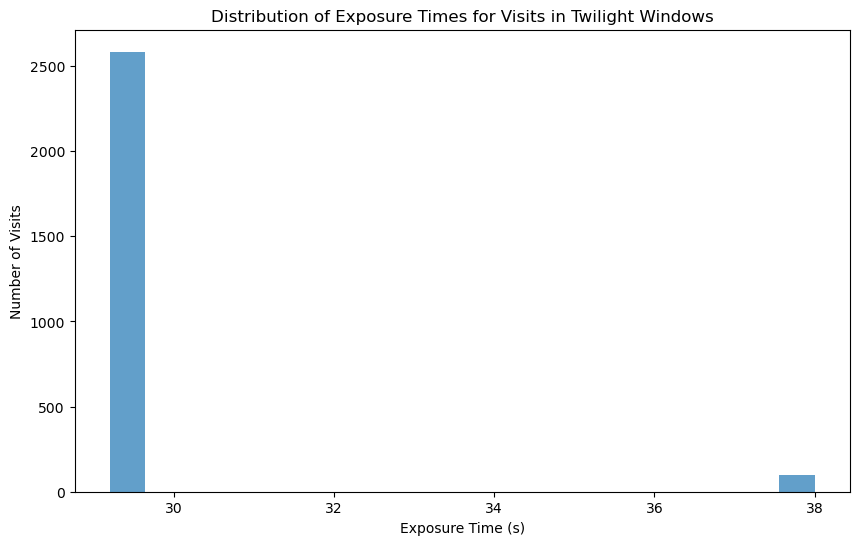

In [75]:
exp_time_limit_mask = [v['exposure_time'] >= 28 for v in visits_in_twilight]
print(f"Visits with exposure time >= 28s: {np.sum(exp_time_limit_mask)} out of {len(visits_in_twilight)}")
fig, ax = plt.subplots(figsize=(10,6))
ax.hist([v['exposure_time'] for v in np.array(visits_in_twilight)[exp_time_limit_mask]], bins=20, alpha=0.7)
ax.set_xlabel('Exposure Time (s)')
ax.set_ylabel('Number of Visits')
ax.set_title('Distribution of Exposure Times for Visits in Twilight Windows')
plt.show()

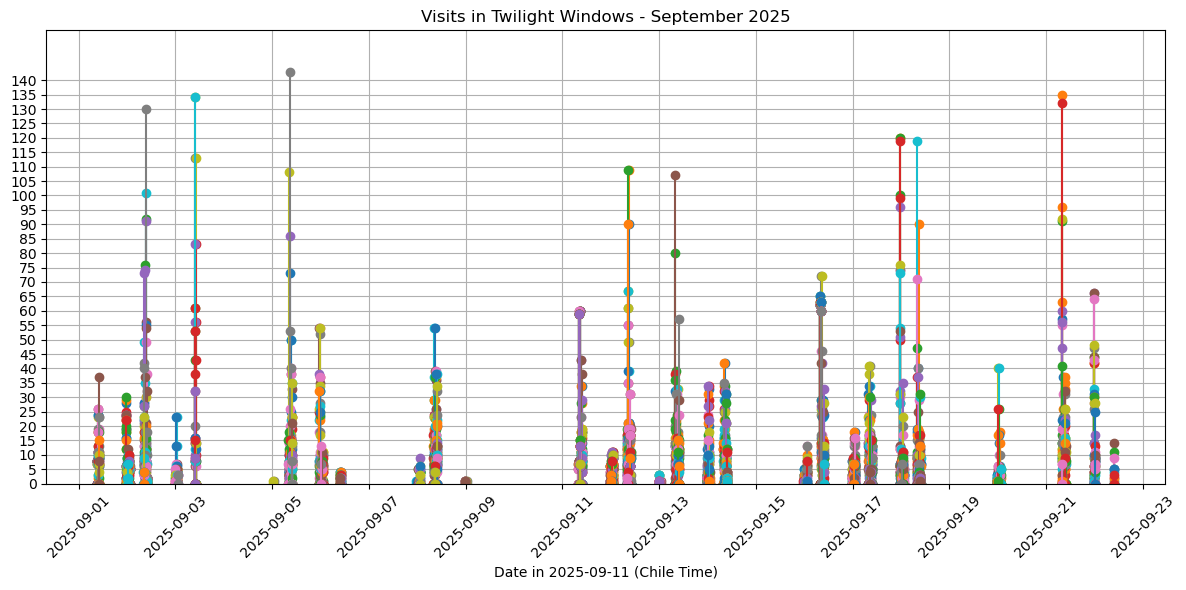

2025-09-01 05:08:55.731611-04:00


In [76]:
#plot target numbers per visits over may timeline 
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(12,6))
for visit in visits_in_twilight:
    ax.plot([visit['chile_time'], visit['chile_time']], [0, len(visit['targets'])], marker='o', label=f"Visit {visit['visit_id']} ({visit['exposure_time']}s)")
ax.set_ylim(0, max(len(v['targets']) for v in visits_in_twilight) * 1.1)
ax.set_yticks(range(0, max(len(v['targets']) for v in visits_in_twilight) + 1, 5))
ax.set_xlabel(f'Date in {visit_chile_time.date()} (Chile Time)')
ax.set_title(f'Visits in Twilight Windows - {visit_chile_time.strftime("%B %Y")}')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()
print(np.min([visit['chile_time'] for visit in visits_in_twilight]))

In [77]:
# create a fits file for visits in twilight
from astropy.io import fits
from astropy.table import Table
# Prepare data for FITS table
fits_rows = []
for visit in visits_in_twilight:
    for target in visit['targets']:
        fits_rows.append({
            'visit_id': visit['visit_id'],
            'mjd': visit['mjd'],
            'chile_time': visit['chile_time'].strftime('%Y-%m-%d %H:%M:%S'),
            'exposure_time': visit['exposure_time'],
            'num_exposures': visit['num_exposures'],
            'filter': visit['filter'],
            'field_ra': visit['field_ra'],
            'field_dec': visit['field_dec'],
            'target_id': target['target_id'],
            'target_ra': target['target_ra'],
            'target_dec': target['target_dec'],
            'five_sigma_depth': target['five_sigma_depth'],
            'seeing': target['seeing'],
            'sky_brightness': target['sky_brightness']
        })
# Create an Astropy Table
fits_table = Table(rows=fits_rows)
# Define FITS columns
# Define FITS columns
cols = [
    fits.Column(name='visit_id', format='K', array=fits_table['visit_id']),
    fits.Column(name='mjd', format='D', array=fits_table['mjd']),
    fits.Column(name='chile_time', format='20A', array=fits_table['chile_time']),
    fits.Column(name='exposure_time', format='E', array=fits_table['exposure_time']),
    fits.Column(name='num_exposures', format='I',   array=fits_table['num_exposures']), 
    fits.Column(name='filter', format='1A', array=fits_table['filter']),
    fits.Column(name='field_ra', format='D', array=fits_table['field_ra']),
    fits.Column(name='field_dec', format='D', array=fits_table['field_dec']),
    fits.Column(name='target_id', format='20A', array=fits_table['target_id']),
    fits.Column(name='target_ra', format='D', array=fits_table['target_ra']),
    fits.Column(name='target_dec', format='D', array=fits_table['target_dec']),
    fits.Column(name='five_sigma_depth', format='E', array=fits_table['five_sigma_depth']),
    fits.Column(name='seeing', format='E', array=fits_table['seeing']),
    fits.Column(name='sky_brightness', format='E', array=fits_table['sky_brightness'])
]
hdu = fits.BinTableHDU.from_columns(cols)
# Write to FITS file
fits_filename = 'twilight_visits_sep2025.fits'
hdu.writeto(fits_filename, overwrite=True)
print(f"Written {len(fits_rows)} rows to {fits_filename}")
print(f"FITS columns: {[col.name for col in hdu.columns]}")
# How to set RUBIN_SIM_DATA_DIR

Written 36716 rows to twilight_visits_sep2025.fits
FITS columns: ['visit_id', 'mjd', 'chile_time', 'exposure_time', 'num_exposures', 'filter', 'field_ra', 'field_dec', 'target_id', 'target_ra', 'target_dec', 'five_sigma_depth', 'seeing', 'sky_brightness']


In [65]:
# read the fits file to check
with fits.open('/data/a.saricaoglu/repo/RubinsForge/OpSim/scripts/twilight_visits_may2025.fits') as hdul:
    # print(hdul.info())
    data = hdul[1].data
    print(len(data['visit_id']))
    print(len(np.unique(data['visit_id'])))
    print(len(np.unique(data['target_id'])))
    print(f"First 5 rows of data:")
    for visit in np.unique(data['visit_id']):
        if visit != 2368:
            continue
         # Extract data for this visit
        visit_mask = data['visit_id'] == visit
        visit_data = data[visit_mask]
        print(Time(visit_data['mjd'][0], format='mjd').to_datetime(timezone=chile_tz).date())
        print(f"\nVisit ID: {visit}")
        print(f'Visit fieldRa: {visit_data["field_ra"][0]:.4f}°, fieldDec: {visit_data["field_dec"][0]:.4f}°')
        print(visit_data['target_id'])
        print(visit_data['target_ra'])
        print(visit_data['target_dec'])
        print(visit_data['exposure_time'])
        print(visit_data['num_exposures'])
        
        # for row in visit_data[:4]:
        #     print(row['target_id'], row['target_ra'], row['target_dec'])
        # for row in visit_data :
        #      if row['num_exposures'] > 1:
        #         if row['exposure_time']:
        #             print(f" Exposure: {row['exposure_time']}s, Exposure number {row['num_exposures']} [Depth: {row['five_sigma_depth']:.2f}, Seeing: {row['seeing']:.2f}, Sky Brightness: {row['sky_brightness']:.2f}")

70672
2835
4366
First 5 rows of data:
2025-05-03

Visit ID: 2368
Visit fieldRa: 168.2338°, fieldDec: 3.9542°
['target_9479' 'target_9497' 'target_9505' 'target_9512' 'target_9515'
 'target_9568' 'target_9574' 'target_9581' 'target_9595' 'target_9613'
 'target_9616' 'target_9651']
[166.72383 167.07375 167.1677  167.284   167.29395 168.12807 168.2115
 168.44868 168.65817 168.96752 168.9901  169.59242]
[3.95464 2.87814 2.39933 2.70403 4.8975  4.53147 2.49125 2.64115 2.61579
 3.35987 4.04008 3.63393]
[29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2 29.2]
[2 2 2 2 2 2 2 2 2 2 2 2]


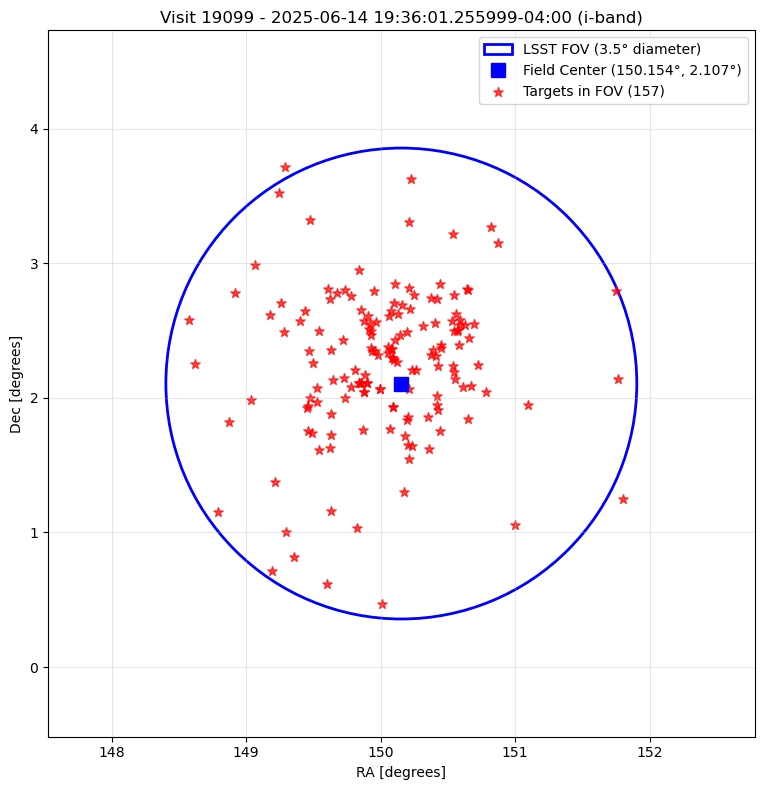

In [27]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.patches as patches

def plot_visit_fov_and_targets(visit_data, targets_dict, fov_radius_deg=1.75):
    """
    Plot visit field of view and targets on a standard RA/Dec sky plot
    
    Parameters:
    -----------
    visit_data : dict
        Visit information containing field_ra, field_dec, targets, etc.
    targets_dict : dict
        Dictionary of all targets with coordinates
    fov_radius_deg : float
        LSST FOV radius in degrees (default 1.75° for 3.5° diameter)
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get field center
    field_ra = visit_data['field_ra']
    field_dec = visit_data['field_dec']
    
    # Plot field of view circle
    fov_circle = plt.Circle((field_ra, field_dec), fov_radius_deg, 
                           fill=False, color='blue', linewidth=2, 
                           label=f'LSST FOV ({fov_radius_deg*2:.1f}° diameter)')
    ax.add_patch(fov_circle)
    
    # Plot field center
    ax.plot(field_ra, field_dec, 'bs', markersize=10, 
            label=f'Field Center ({field_ra:.3f}°, {field_dec:.3f}°)')
    
    # Plot all targets in this visit
    target_ras = []
    target_decs = []
    for target in visit_data['targets']:
        target_id = target['target_id']
        if target_id in targets_dict:
            target_ras.append(targets_dict[target_id]['ra'])
            target_decs.append(targets_dict[target_id]['dec'])
    
    if target_ras:
        ax.scatter(target_ras, target_decs, c='red', s=50, alpha=0.7, 
                  marker='*', label=f'Targets in FOV ({len(target_ras)})')
    
    # Set axis properties
    ax.set_xlabel('RA [degrees]')
    ax.set_ylabel('Dec [degrees]')
    ax.set_title(f'Visit {visit_data["visit_id"]} - {visit_data["chile_time"]} ({visit_data["filter"]}-band)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set equal aspect ratio and reasonable limits
    ax.set_aspect('equal')
    margin = fov_radius_deg * 1.5
    ax.set_xlim(field_ra - margin, field_ra + margin)
    ax.set_ylim(field_dec - margin, field_dec + margin)
    
    plt.tight_layout()
    return fig, ax

# Example usage with your data:
# Find a visit with multiple targets
multi_target_visits = [v for v in visit_exposure_groups.values() if len(v['targets']) > 1]
if multi_target_visits:
    example_visit = multi_target_visits[0]
    fig, ax = plot_visit_fov_and_targets(example_visit, targets_in_footprint)
    plt.show()

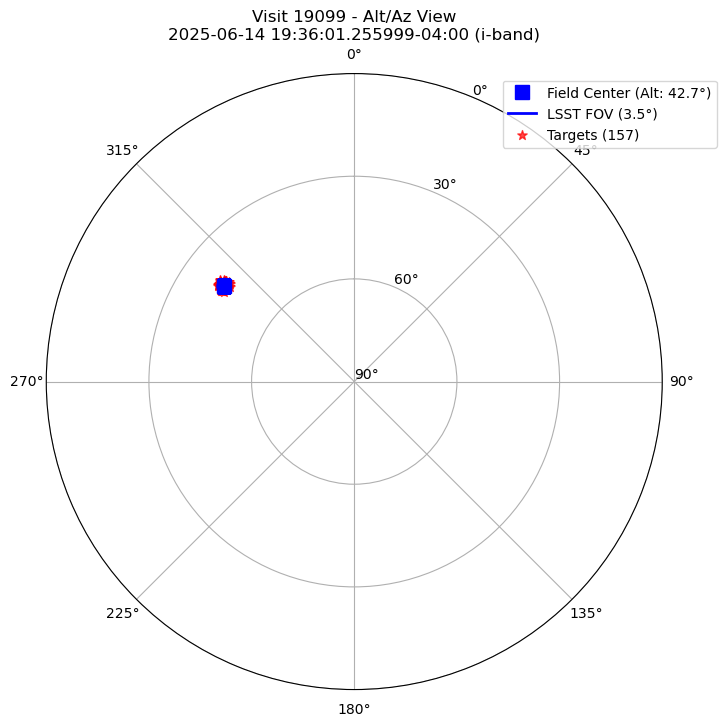

In [63]:
from astropy.coordinates import AltAz, EarthLocation
from astropy.time import Time

def plot_visit_fov_polar(visit_data, targets_dict, fov_radius_deg=1.75):
    """
    Plot visit FOV and targets on polar plot in Alt/Az coordinates
    """
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    # Set up time and location for coordinate transformation
    obs_time = Time(visit_data['mjd'], format='mjd')
    rubin_location = EarthLocation.of_site('rubin')
    altaz_frame = AltAz(obstime=obs_time, location=rubin_location)
    
    # Transform field center to Alt/Az
    field_coord = SkyCoord(ra=visit_data['field_ra']*u.deg, 
                          dec=visit_data['field_dec']*u.deg, frame='icrs')
    field_altaz = field_coord.transform_to(altaz_frame)
    
    # Convert to polar coordinates (radius = 90 - altitude, theta = azimuth)
    field_theta = np.radians(field_altaz.az.deg)
    field_r = 90 - field_altaz.alt.deg
    
    # Plot field center
    ax.plot(field_theta, field_r, 'bs', markersize=10, 
            label=f'Field Center (Alt: {field_altaz.alt.deg:.1f}°)')
    
    # Plot FOV circle
    plot_fov_circle_polar(ax, field_altaz.alt.deg, field_altaz.az.deg, fov_radius_deg*2)
    
    # Plot targets in this visit
    target_coords = []
    for target in visit_data['targets']:
        target_id = target['target_id']
        if target_id in targets_dict:
            coord = SkyCoord(ra=targets_dict[target_id]['ra']*u.deg,
                           dec=targets_dict[target_id]['dec']*u.deg, frame='icrs')
            target_coords.append(coord)
    
    if target_coords:
        target_coords = SkyCoord(target_coords)
        target_altaz = target_coords.transform_to(altaz_frame)
        
        target_theta = np.radians(target_altaz.az.deg)
        target_r = 90 - target_altaz.alt.deg
        
        ax.scatter(target_theta, target_r, c='red', s=50, alpha=0.7,
                  marker='*', label=f'Targets ({len(target_coords)})')
    
    # Configure polar plot
    ax.set_theta_zero_location('N')  # North at top
    ax.set_theta_direction(-1)       # Clockwise
    ax.set_ylim(0, 90)              # 0 = zenith, 90 = horizon
    ax.set_yticks([0, 30, 60, 90])
    ax.set_yticklabels(['90°', '60°', '30°', '0°'])  # Altitude labels
    ax.set_title(f'Visit {visit_data["visit_id"]} - Alt/Az View\n{visit_data["chile_time"]} ({visit_data["filter"]}-band)')
    ax.legend(bbox_to_anchor=(1.1, 1.0))
    
    return fig, ax

def plot_fov_circle_polar(ax, center_alt_deg, center_az_deg, diameter_deg):
    """Plot FOV circle on polar plot"""
    radius_deg = diameter_deg / 2
    
    # Generate circle points
    angles = np.linspace(0, 2*np.pi, 100)
    
    circle_alt = []
    circle_az = []
    
    for angle in angles:
        # Simple circular approximation for small circles
        delta_alt = radius_deg * np.cos(angle)
        delta_az = radius_deg * np.sin(angle) / np.cos(np.radians(center_alt_deg))
        
        alt = center_alt_deg + delta_alt
        az = center_az_deg + delta_az
        
        # Handle azimuth wrapping
        az = az % 360
        
        # Only include points above horizon
        if alt >= 0 and alt <= 90:
            circle_alt.append(alt)
            circle_az.append(az)
    
    if circle_alt:
        circle_theta = np.radians(circle_az)
        circle_r = 90 - np.array(circle_alt)
        ax.plot(circle_theta, circle_r, 'b-', linewidth=2, label=f'LSST FOV ({diameter_deg:.1f}°)')

# Example usage:
if multi_target_visits:
    fig, ax = plot_visit_fov_polar(multi_target_visits[0], targets_in_footprint)
    plt.show()

/tmp/ipykernel_755364/1121614530.py:35: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(target_ras, target_decs, c=color, s=30, marker='*', alpha=0.8)


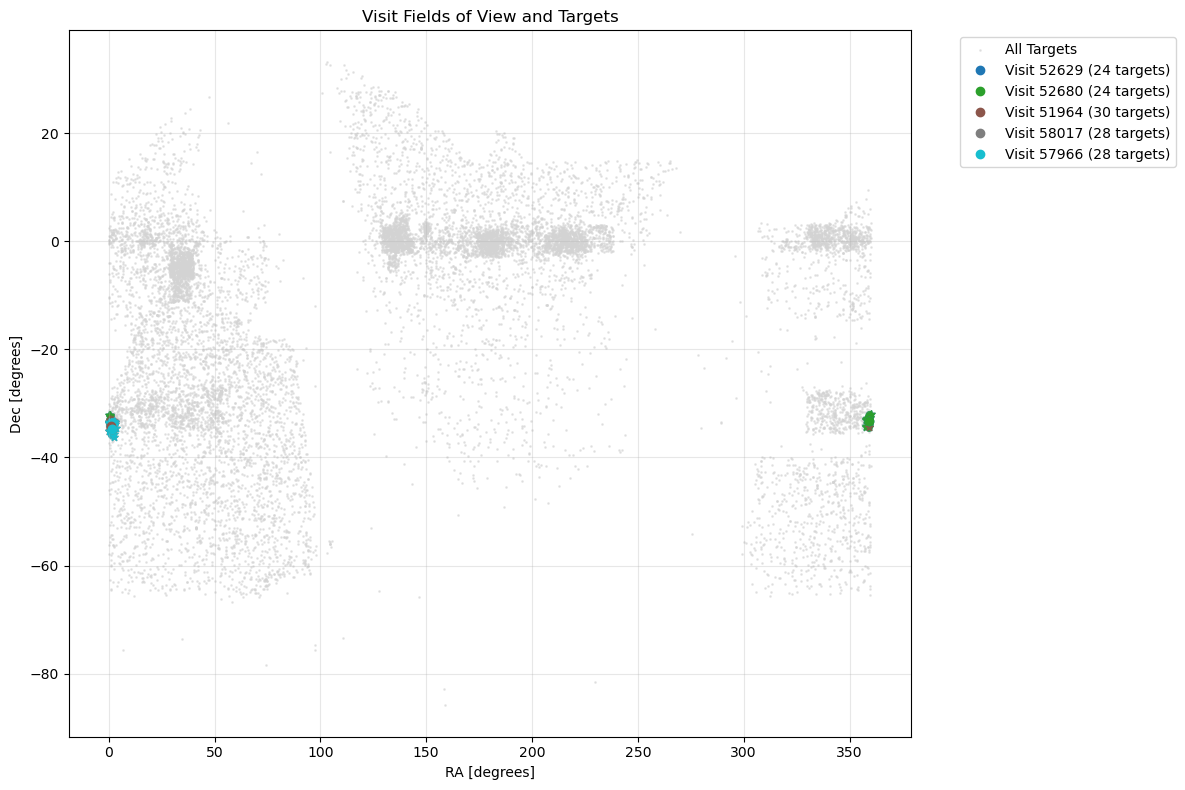

In [62]:
def plot_all_visits_and_targets(visit_groups, targets_dict, max_visits=10):
    """
    Plot multiple visits and all targets on an all-sky view
    """
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot all targets first as background
    all_ras = [targets_dict[tid]['ra'] for tid in targets_dict.keys()]
    all_decs = [targets_dict[tid]['dec'] for tid in targets_dict.keys()]
    ax.scatter(all_ras, all_decs, c='lightgray', s=1, alpha=0.5, label='All Targets')
    
    # Plot visit fields
    colors = plt.cm.tab10(np.linspace(0, 1, min(len(visit_groups), max_visits)))
    
    for i, (visit_key, visit_data) in enumerate(list(visit_groups.items())[:max_visits]):
        if len(visit_data['targets']) == 0:
            continue
            
        color = colors[i % len(colors)]
        field_ra = visit_data['field_ra']
        field_dec = visit_data['field_dec']
        
        # Plot FOV circle
        fov_circle = plt.Circle((field_ra, field_dec), 1.75, 
                               fill=False, color=color, linewidth=1.5, alpha=0.7)
        ax.add_patch(fov_circle)
        
        # Plot field center
        ax.plot(field_ra, field_dec, 'o', color=color, markersize=6,
                label=f'Visit {visit_data["visit_id"]} ({len(visit_data["targets"])} targets)')
        
        # Plot targets in this visit
        target_ras = [t['target_ra'] for t in visit_data['targets']]
        target_decs = [t['target_dec'] for t in visit_data['targets']]
        ax.scatter(target_ras, target_decs, c=color, s=30, marker='*', alpha=0.8)
    
    ax.set_xlabel('RA [degrees]')
    ax.set_ylabel('Dec [degrees]')
    ax.set_title(f'Visit Fields of View and Targets')
    ax.grid(True, alpha=0.3)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    return fig, ax

# Plot multiple visits
fig, ax = plot_all_visits_and_targets(visit_exposure_groups, targets_in_footprint, max_visits=5)
plt.show()

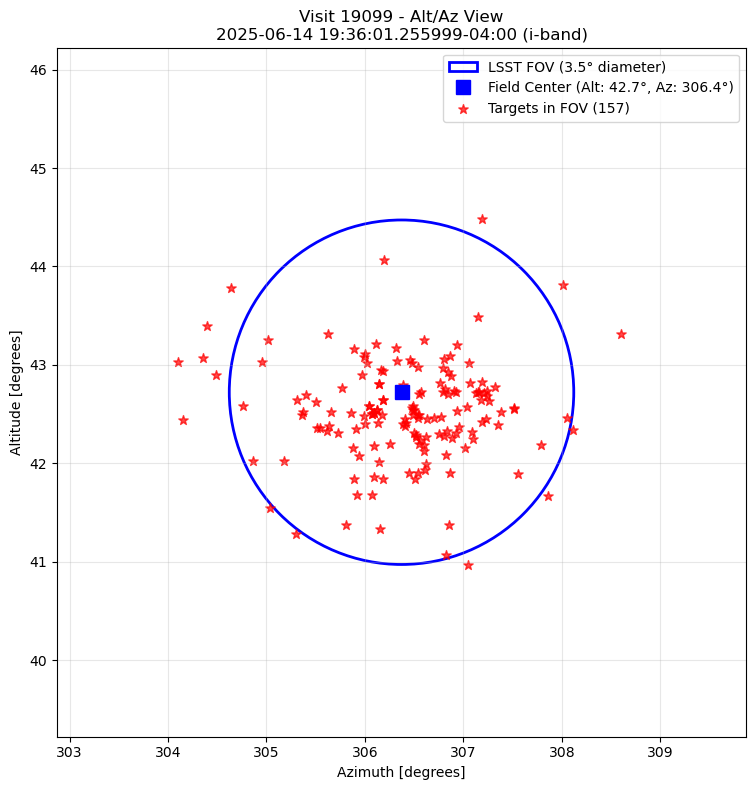

In [64]:
def plot_visit_fov_and_targets_altaz(visit_data, targets_dict, fov_radius_deg=1.75):
    """
    Plot visit field of view and targets on Alt/Az Cartesian coordinates
    
    Parameters:
    -----------
    visit_data : dict
        Visit information containing field_ra, field_dec, targets, etc.
    targets_dict : dict
        Dictionary of all targets with coordinates
    fov_radius_deg : float
        LSST FOV radius in degrees (default 1.75° for 3.5° diameter)
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Set up time and location for coordinate transformation
    obs_time = Time(visit_data['mjd'], format='mjd')
    rubin_location = EarthLocation.of_site('rubin')
    altaz_frame = AltAz(obstime=obs_time, location=rubin_location)
    
    # Transform field center to Alt/Az
    field_coord = SkyCoord(ra=visit_data['field_ra']*u.deg, 
                          dec=visit_data['field_dec']*u.deg, frame='icrs')
    field_altaz = field_coord.transform_to(altaz_frame)
    
    # Get Alt/Az coordinates for plotting
    field_alt = field_altaz.alt.deg
    field_az = field_altaz.az.deg
    
    # Plot field of view circle
    fov_circle = plt.Circle((field_az, field_alt), fov_radius_deg, 
                           fill=False, color='blue', linewidth=2, 
                           label=f'LSST FOV ({fov_radius_deg*2:.1f}° diameter)')
    ax.add_patch(fov_circle)
    
    # Plot field center
    ax.plot(field_az, field_alt, 'bs', markersize=10, 
            label=f'Field Center (Alt: {field_alt:.1f}°, Az: {field_az:.1f}°)')
    
    # Plot all targets in this visit, transformed to Alt/Az
    target_coords = []
    for target in visit_data['targets']:
        target_id = target['target_id']
        if target_id in targets_dict:
            coord = SkyCoord(ra=targets_dict[target_id]['ra']*u.deg,
                           dec=targets_dict[target_id]['dec']*u.deg, frame='icrs')
            target_coords.append(coord)
    
    if target_coords:
        target_coords = SkyCoord(target_coords)
        target_altaz = target_coords.transform_to(altaz_frame)
        
        ax.scatter(target_altaz.az.deg, target_altaz.alt.deg, 
                  c='red', s=50, alpha=0.7, marker='*', 
                  label=f'Targets in FOV ({len(target_coords)})')
    
    # Set axis properties
    ax.set_xlabel('Azimuth [degrees]')
    ax.set_ylabel('Altitude [degrees]')
    ax.set_title(f'Visit {visit_data["visit_id"]} - Alt/Az View\n{visit_data["chile_time"]} ({visit_data["filter"]}-band)')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Set reasonable limits around the field center
    margin = fov_radius_deg * 2
    ax.set_xlim(field_az - margin, field_az + margin)
    ax.set_ylim(max(0, field_alt - margin), min(90, field_alt + margin))
    
    # Add horizon line at altitude = 0
    ax.axhline(y=0, color='brown', linestyle='--', alpha=0.5, label='Horizon')
    
    # Set equal aspect ratio
    ax.set_aspect('equal')
    
    plt.tight_layout()
    return fig, ax

# Example usage with your existing data:
if multi_target_visits:
    example_visit = multi_target_visits[0]
    fig, ax = plot_visit_fov_and_targets_altaz(example_visit, targets_in_footprint)
    plt.show()

In [28]:
with fits.open(fits_filename) as hdul:
    # print(hdul.info())
    data = hdul[1].data
    print(len(data['visit_id']))
    print(len(np.unique(data['visit_id'])))
    print(len(np.unique(data['target_id'])))
    print(f"First 5 rows of data:")
    for target in np.unique(data['target_id'])[:5]:
        target_mask = data['target_id'] == target
        target_data = data[target_mask]
        print(f"\nTarget ID: {target}")
        # print(target_data['visit_id'])
        print(target_data['target_ra'])
        print(target_data['target_dec'])

37134
1988
3157
First 5 rows of data:



Target ID: target_0000
[149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407 149.8407
 149.8407 149.8407 149.8407

In [29]:
# def get_targets_with_visits_in_range(bundle_list, targets_dict, start_mjd, end_mjd):
#     """Find targets with visits in a date range"""
#     targets_with_visits = {}
#     target_ids = list(targets_dict.keys())
    
#     for i, target_observations in enumerate(bundle_list[0].metric_values):
#         if i >= len(target_ids):
#             break
            
#         target_id = target_ids[i]
#         target_info = targets_dict[target_id]
        
#         # Filter observations for the date range
#         range_mask = (target_observations['observationStartMJD'] >= start_mjd) & \
#                     (target_observations['observationStartMJD'] <= end_mjd)
        
#         range_observations = target_observations[range_mask]
        
#         if len(range_observations) > 0:
#             # Group by unique nights
#             unique_nights = np.unique(range_observations['observationStartMJD'].astype(int))
            
#             targets_with_visits[target_id] = {
#                 'target_info': target_info,
#                 'n_observations': len(range_observations),
#                 'n_nights': len(unique_nights),
#                 'observations': range_observations,
#                 'filters_observed': list(set(range_observations['filter'])),
#                 'observation_nights': unique_nights
#             }
    
#     return targets_with_visits

# def get_targets_observed_in_filter(bundle_list, targets_dict, filter_name, date_mjd=None):
#     """Find targets observed in a specific filter, optionally on a specific date"""
#     targets_in_filter = {}
#     target_ids = list(targets_dict.keys())
    
#     for i, target_observations in enumerate(bundle_list[0].metric_values):
#         if i >= len(target_ids):
#             break
            
#         target_id = target_ids[i]
#         target_info = targets_dict[target_id]
        
#         # Filter by filter type
#         filter_mask = target_observations['filter'] == filter_name
        
#         # Optionally filter by date
#         if date_mjd is not None:
#             date_mask = np.abs(target_observations['observationStartMJD'] - date_mjd) < 0.5
#             combined_mask = filter_mask & date_mask
#         else:
#             combined_mask = filter_mask
        
#         filtered_observations = target_observations[combined_mask]
        
#         if len(filtered_observations) > 0:
#             targets_in_filter[target_id] = {
#                 'target_info': target_info,
#                 'n_observations': len(filtered_observations),
#                 'observations': filtered_observations
#             }
    
#     return targets_in_filter

# # Example usage:

# # 1. Find targets observed in a month
# start_date = dt.datetime(2025, 6, 1, 0, 0, 0, 0).astimezone(chile_tz)
# end_date = dt.datetime(2025, 6, 2, 7,12,0,0).astimezone(chile_tz)
# start_mjd = Time(start_date).mjd
# end_mjd = Time(end_date).mjd

# targets_on_date = get_targets_with_visits_in_range(bundle_list, targets_in_footprint, start_mjd, end_mjd)
# print(f"\nTargets observed in May 2025:")
# for target_id, data in list(targets_on_date.items())[:5]:  # Show first 5
#     print(f"  {target_id}: {data['n_observations']} obs on {data['n_nights']} nights")

# # 2. Find targets observed in r-band on a specific date
# r_band_targets = get_targets_observed_in_filter(bundle_list, targets_in_footprint, 'r')
# # print(f"\nTargets observed in r-band on {target_date.strftime('%Y-%m-%d')}: {len(r_band_targets)}")

# # 3. Summary statistics for observations on a specific date
# if targets_on_date:
#     total_obs = sum([data['n_observations'] for data in targets_on_date.values()])
#     all_filters = set()
#     for data in targets_on_date.values():
#         all_filters.update(data['filters_observed'])
    
#     print(f"  Total targets observed: {len(targets_on_date)}")
#     print(f"  Total observations: {total_obs}")
#     print(f"  Filters used: {', '.join(sorted(all_filters))}")

In [30]:
# filename = '/data/a.saricaoglu/repo/RubinsForge/Skyfield/scripts/twilight_windows_20250501T0000_to_20250531T0000.npz'

# data = np.load(filename)
# twilight_data = data['twilight_data']

# print(f"Loaded {len(twilight_data)} twilight events")
# windows = []
# # Extract twilight events
# print("\nTwilight Events:")
# window = []
# for i, event in enumerate(twilight_data):
#     event_type = event['type']
#     event_mjd = event['mjd']
#     if len(window) != 2:
#         window.append(event_mjd)
#     if len(window) == 2:
#         windows.append(window)
#         window = []
        
#     print(f"  {i+1}: {event_type} at MJD {event_mjd:.6f}")
# print(windows)
    



In [31]:
#Now let's check if any visits fall into the twilight windows
for day in monthly_visits:
    day_data = monthly_visits[day]
    print(f"\nChecking twilight overlaps for {day}:")
    counter = 0
    for target_id, target_data in day_data.items():
        visits = target_data['visits']
        
        for visit in visits:
            visit_mjd = visit['mjd']
            visit_chile_time = visit['chile_time']
            visit['twilight_overlap'] = False
            
            # Check if visit falls within any twilight window
            for window in windows:
                start_mjd, end_mjd = window
                if start_mjd <= visit_mjd <= end_mjd:
                    counter += 1
                    visit['twilight_overlap'] = True
                # obs_time = Time(obs['observationStartMJD'], format='mjd')
                    # print(f"  Target {target_id} has a visit at Chile Time {visit_chile_time} " +
                    #   f"which falls within twilight window {Time(start_mjd, format='mjd').to_datetime(timezone=chile_tz)} to {Time(end_mjd, format='mjd').to_datetime(timezone=chile_tz)}")
                    break  # No need to check other windows for this visit
    print(f"Total twilight-overlapping visits on {day}: {counter}")
print(monthly_visits)

NameError: name 'monthly_visits' is not defined

In [ ]:
# Now we plot the visits on twilight windows for May first
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

day = '2025-05-01'
day_data = monthly_visits[day]
visits_on_twilight = [visit for target_id, target_data in day_data.items() for visit in target_data['visits'] if visit.get('twilight_overlap', False)]
print(len(visits_on_twilight))

# fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': 'polar'})
# for visit in visits_on_twilight:
#     print(f"Target visit at Chile Time {visit['chile_time']} in filter {visit['filter']}")
#     # Plotting
#     visit_coords = SkyCoord(ra=visit['fieldRA']*u.degree, dec=visit['fieldDec']*u.degree, frame='icrs')
#     altaz_frame = AltAz(obstime=Time(visit['mjd'], format='mjd'), location=EarthLocation.of_site('Rubin Observatory'))
#     visit_altaz = visit_coords.transform_to(altaz_frame)
# ax.plot(np.radians(visit_altaz.az.degree), 90 - visit_altaz.alt.degree, 'o', label=f"{visit['filter']}-band")   
# plt.title(f"Visits during Twilight on {day}")
# plt.legend()
# plt.show()
def categorize_by_minute_bins(visits_on_twilight, bin_size_minutes=0.5):
    """Categorize visits by minute bins"""
    
    from collections import defaultdict
    import datetime as dt
    
    minute_bins = defaultdict(list)
    
    for visit in visits_on_twilight:
        chile_time = visit['chile_time']
        
        # Round down to the nearest bin
        total_minutes = chile_time.hour * 60 + chile_time.minute
        bin_start_minutes = (total_minutes // bin_size_minutes) * bin_size_minutes
        bin_end_minutes = bin_start_minutes + bin_size_minutes
        
        # Convert back to hours and minutes
        start_hour = bin_start_minutes // 60
        start_min = bin_start_minutes// 60
        start_sec = int((bin_start_minutes % 60))
        end_hour = bin_end_minutes // 60
        end_min = bin_end_minutes// 60
        end_sec = int((bin_end_minutes % 60))
        
        # Handle day overflow
        if end_hour >= 24:
            end_hour = 0

        bin_label = f"{start_hour:02d}:{start_min:02d}:{start_sec:02d}-{end_hour:02d}:{end_min:02d}:{end_sec:02d}"
        minute_bins[bin_label].append(visit)
    minute_bins = dict(sorted(minute_bins.items()))
    return dict(minute_bins)

# Use with 10-minute bins
minute_categories = categorize_by_minute_bins(visits_on_twilight, bin_size_minutes=1)

print("VISITS BY 10-MINUTE BINS (Precise)")
print("="*45)
for time_bin in sorted(minute_categories.keys()):
    visits = minute_categories[time_bin]
    print(f"{time_bin}: {len(visits)} visits")
    
    if visits:
        filters = [visit['filter'] for visit in visits]
        filter_counts = {f: filters.count(f) for f in set(filters)}
        print(f"  Filters: {filter_counts}")
        
        # Show actual visit times within this bin
        times = [v['chile_time'].strftime('%H:%M:%S') for v in visits]
        print(f"  Times: {', '.join(times[:5])}" + 
              (f" ... +{len(times)-5} more" if len(times) > 5 else ""))

# fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': 'aitoff'})
# for visit in visits_on_twilight:
#     print(f"Target visit at Chile Time {visit['chile_time']} in filter {visit['filter']}")
#     # Plotting
#     visit_coords = SkyCoord(ra=visit['fieldRA']*u.degree, dec=visit['fieldDec']*u.degree, frame='icrs')
#     ax.plot(np.radians(visit_coords.ra.wrap_at(180*u.degree).degree), np.radians(visit_coords.dec.degree), 'o', label=f"{visit['filter']}-band")   
# plt.title(f"Visits during Twilight on {day}")
# plt.legend()
# plt.grid(True)
# plt.show()

570
VISITS BY 10-MINUTE BINS (Precise)
05:05:58-05:05:59: 16 visits
  Filters: {'r': 16}
  Times: 05:58:46, 05:58:46, 05:58:46, 05:58:25, 05:58:25 ... +11 more
05:05:59-06:06:00: 34 visits
  Filters: {'r': 34}
  Times: 05:59:07, 05:59:07, 05:59:48, 05:59:48, 05:59:48 ... +29 more
06:06:00-06:06:01: 68 visits
  Filters: {'r': 68}
  Times: 06:00:50, 06:00:50, 06:00:09, 06:00:09, 06:00:09 ... +63 more
06:06:01-06:06:02: 19 visits
  Filters: {'r': 19}
  Times: 06:01:32, 06:01:32, 06:01:52, 06:01:32, 06:01:32 ... +14 more
06:06:02-06:06:03: 13 visits
  Filters: {'r': 13}
  Times: 06:02:55, 06:02:55, 06:02:13, 06:02:55, 06:02:13 ... +8 more
06:06:03-06:06:04: 35 visits
  Filters: {'r': 35}
  Times: 06:03:37, 06:03:16, 06:03:37, 06:03:16, 06:03:16 ... +30 more
06:06:04-06:06:05: 54 visits
  Filters: {'r': 54}
  Times: 06:04:39, 06:04:39, 06:04:39, 06:04:39, 06:04:39 ... +49 more
06:06:05-06:06:06: 25 visits
  Filters: {'r': 25}
  Times: 06:05:20, 06:05:20, 06:05:20, 06:05:20, 06:05:20 ... +20

Earliest observation in dataset: MJD 2025-05-01 00:32:54.141
Total observations for 13746 targets: 40779
From loaded data:
Survey start: 2025-05-02 01:03:28.693 (MJD 60797.0)
Survey end: 2035-04-30 01:16:45.169 (MJD 64447.1)
Duration: 10.0 years
Observation period: MJD 60797 to 64447


/data/a.saricaoglu/repo/RubinsForge/lsstsw/miniconda/envs/lsst-scipipe-v29_2_0/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


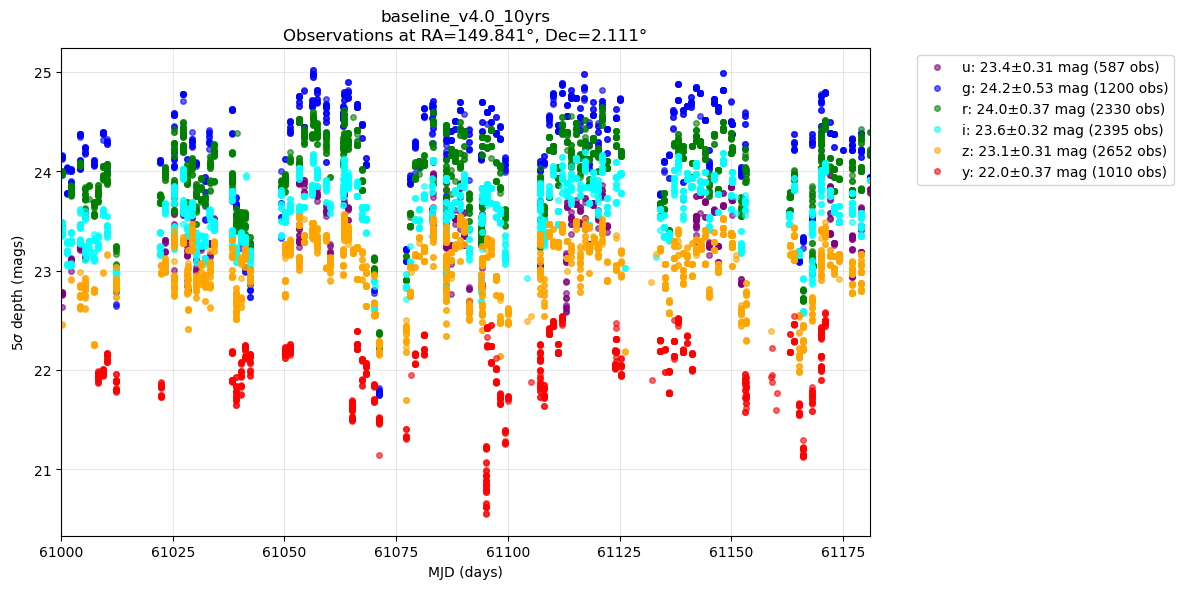


OBSERVATION SUMMARY for RA=149.841°, Dec=2.111°
Total observations: 40779
Time range: 61000 - 61181 MJD
Observations in time range: 10174

FILTER PERFORMANCE:
Filter   Mean Depth   Std      Range           N_obs   
-------------------------------------------------------
g        24.25        0.525    21.7-25.0       1200    
i        23.61        0.320    22.6-24.2       2395    
r        24.00        0.373    22.2-24.7       2330    
u        23.42        0.310    22.6-24.0       587     
y        21.98        0.366    20.6-22.6       1010    
z        23.06        0.307    21.7-23.6       2652    

DEEPEST FILTER: g (mean depth: 24.25 mag)
SHALLOWEST FILTER: y (mean depth: 21.98 mag)
DEPTH RANGE: 2.27 magnitudes between deepest and shallowest filters


In [ ]:
# As a bit of foreshadowing for how the rest of MAF works, we'll call the visits overlapping a
# single point in the sky "dataSlice". 


data_slice_total = bundle_list[0].metric_values[0][:]
print(f"Total observations for {len(ra)} targets: {len(data_slice_total)}")

start_mjd = np.min(data_slice_total['observationStartMJD'])
end_mjd = np.max(data_slice_total['observationStartMJD'])

start_time = Time(start_mjd, format='mjd')
end_time = Time(end_mjd, format='mjd')

print(f"From loaded data:")
print(f"Survey start: {start_time.iso} (MJD {start_mjd:.1f})")
print(f"Survey end: {end_time.iso} (MJD {end_mjd:.1f})")
print(f"Duration: {(end_mjd - start_mjd)/365.25:.1f} years")

print(f"Observation period: MJD {start_mjd:.0f} to {end_mjd:.0f}")

# Observation period start and end
start = 61000 # MJD, 2025-11-21
end = 61181   # MJD, 2026-05-21
# Update data_slice to only include observations within the specified time range
data_slice = data_slice_total[(data_slice_total['observationStartMJD'] >= start) & (data_slice_total['observationStartMJD'] <= end)]

# Let's plot up what the 5-sigma depth looks like
plt.figure(figsize=(12, 6))

# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

# Track statistics for each filter
filter_stats = {}

for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    if len(in_filt) > 0:  # Only plot if we have data
        depths = data_slice['fiveSigmaDepth'][in_filt]
        mjds = data_slice['observationStartMJD'][in_filt]
        
        plt.plot(mjds, depths, 'o',
                 color=f2c[fn],
                 label=f'{fn}: {np.mean(depths):.1f}±{np.std(depths):.2f} mag ({len(in_filt)} obs)',
                 alpha=0.6, markersize=4)
        
        # Store statistics
        filter_stats[fn] = {
            'mean_depth': np.mean(depths),
            'std_depth': np.std(depths),
            'min_depth': np.min(depths),
            'max_depth': np.max(depths),
            'n_obs': len(in_filt)
        }

plt.xlim(start, end)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f'{name}\nObservations at RA={ra[0]:.3f}°, Dec={dec[0]:.3f}°')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print detailed statistics
print(f'\n{"="*60}')
print(f'OBSERVATION SUMMARY for RA={ra[0]:.3f}°, Dec={dec[0]:.3f}°')
print(f'{"="*60}')
print(f'Total observations: {len(data_slice_total)}')
print(f'Time range: {start} - {end} MJD')
time_filtered = data_slice_total[(data_slice_total["observationStartMJD"] >= start) & (data_slice_total["observationStartMJD"] <= end)]
print(f'Observations in time range: {len(time_filtered)}')

print(f'\nFILTER PERFORMANCE:')
print(f'{"Filter":<8} {"Mean Depth":<12} {"Std":<8} {"Range":<15} {"N_obs":<8}')
print(f'{"-"*55}')
for fn in sorted(filter_stats.keys()):
    stats = filter_stats[fn]
    range_str = f"{stats['min_depth']:.1f}-{stats['max_depth']:.1f}"
    print(f'{fn:<8} {stats["mean_depth"]:<12.2f} {stats["std_depth"]:<8.3f} {range_str:<15} {stats["n_obs"]:<8}')

# Find deepest and shallowest filters
if filter_stats:
    deepest_filter = max(filter_stats.keys(), key=lambda x: filter_stats[x]['mean_depth'])
    shallowest_filter = min(filter_stats.keys(), key=lambda x: filter_stats[x]['mean_depth'])
    
    print(f'\nDEEPEST FILTER: {deepest_filter} (mean depth: {filter_stats[deepest_filter]["mean_depth"]:.2f} mag)')
    print(f'SHALLOWEST FILTER: {shallowest_filter} (mean depth: {filter_stats[shallowest_filter]["mean_depth"]:.2f} mag)')
    
    depth_range = filter_stats[deepest_filter]['mean_depth'] - filter_stats[shallowest_filter]['mean_depth']
    print(f'DEPTH RANGE: {depth_range:.2f} magnitudes between deepest and shallowest filters')

### Practical Example: What Can We Detect?

The 5-sigma depth tells us the **faintest magnitude** we can reliably detect. Here's what different depths mean:

#### Typical LSST 5σ Depths:
- **u-band**: ~23.5 mag (shallowest due to atmosphere)
- **g-band**: ~24.5 mag 
- **r-band**: ~24.0 mag
- **i-band**: ~23.5 mag
- **z-band**: ~22.5 mag
- **y-band**: ~21.5 mag (shallowest due to sky brightness)

#### Real Objects at These Depths:
- **Magnitude 20**: Bright quasars, nearby supernovae
- **Magnitude 22**: Distant galaxies, faint asteroids
- **Magnitude 24**: Very distant galaxies, faint stars in nearby galaxies
- **Magnitude 26**: Galaxy at redshift z~3-4, brown dwarfs

#### Why the Scatter in Your Plot?
1. **Atmospheric seeing**: Better seeing = deeper observations
2. **Sky brightness**: Moon phase and elevation affect background
3. **Airmass**: Objects near horizon are harder to observe
4. **Weather**: Clouds and humidity reduce sensitivity

**Higher 5σ depth = Better observation = Can detect fainter objects!**

## Understanding 5-Sigma Depth

**5-sigma depth** is a key observational metric that tells us **how faint an object we can detect** with high confidence in each observation.

### What it means:
- **5-sigma**: Statistical significance level - we're 99.99994% confident the detection is real (not noise)
- **Depth**: The faintest magnitude we can reliably detect
- **Higher magnitude = fainter object** (astronomical magnitude scale is backwards!)

### Key Points:
- **Deeper observations** (higher 5σ depth values) can detect fainter objects
- **Different filters** have different sensitivities based on:
  - Atmospheric transmission
  - CCD quantum efficiency  
  - Sky brightness in that band
  - Exposure time and seeing conditions

### In LSST Context:
- **u-band**: Typically shallowest due to atmospheric absorption
- **i,z,y-bands**: Often deepest due to good atmospheric transmission and detector response
- **Seeing conditions** and **sky brightness** vary nightly, causing scatter in the plot

In [ ]:
# Now, let's check how seeing changes for different observations of the same target




<function print(*args, sep=' ', end='\n', file=None, flush=False)>